# [ASHRAE - Great Energy Predictor III](https://www.kaggle.com/c/ashrae-energy-prediction/overview)

How much energy will a building consume?


---

Developing energy savings has two key elements: Forecasting future energy usage without improvements, and forecasting energy use after a specific set of improvements have been implemented, like the installation and purchase of investment-grade meters, whose prices continue to fall. One issue preventing more aggressive growth of the energy markets are the lack of cost-effective, accurate, and scalable procedures for forecasting energy use.

**In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.**

With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

## Data Preparation & Prelimarily linear regressions

In [2]:
# standard libraries
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import os

In [3]:
data_dir = '../data/02_intermediate/'
os.listdir(data_dir)

['.DS_Store', '.gitkeep', 'intermediate.h5']

In [4]:
%%time
train = pd.read_hdf(data_dir + 'intermediate.h5', key='train')
#test = pd.read_csv(data_dir + '/test.csv')

CPU times: user 40.2 s, sys: 46 s, total: 1min 26s
Wall time: 2min 30s


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           category
meter                 category
timestamp             datetime64[ns]
meter_reading         float32
site_id               category
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: category(3), datetime64[ns](1), float16(9), float32(1), int32(1), object(1)
memory usage: 1.0+ GB


> Correct column types & reduced data size read from HDF storage

In [7]:
train.describe(include='all')

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,20216100.0,20216100.0,20216100,2.021610e+07,20216100.0,20216100,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07
unique,1449.0,4.0,8784,NaN,16.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1298.0,0.0,2016-12-27 22:00:00,NaN,13.0,Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,35136.0,12060910.0,2370,NaN,2711763.0,8165504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.988706e+03,NaN,NaN,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.532159e+05,NaN,NaN,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00
25%,NaN,NaN,NaN,1.830000e+01,NaN,NaN,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0,1011.5,70.0,2.099609e+00


In [8]:
train.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

## Sample only 10K random dataset
The whole training dataset (~20M records) is too much to process

In [64]:
sample_train = train.sample(n=1000, axis=0, random_state=1000)
sample_train.to_hdf(data_dir + 'sample.h5', key='sample1000', format='table')

In [65]:
sample_train.shape

(1000, 16)

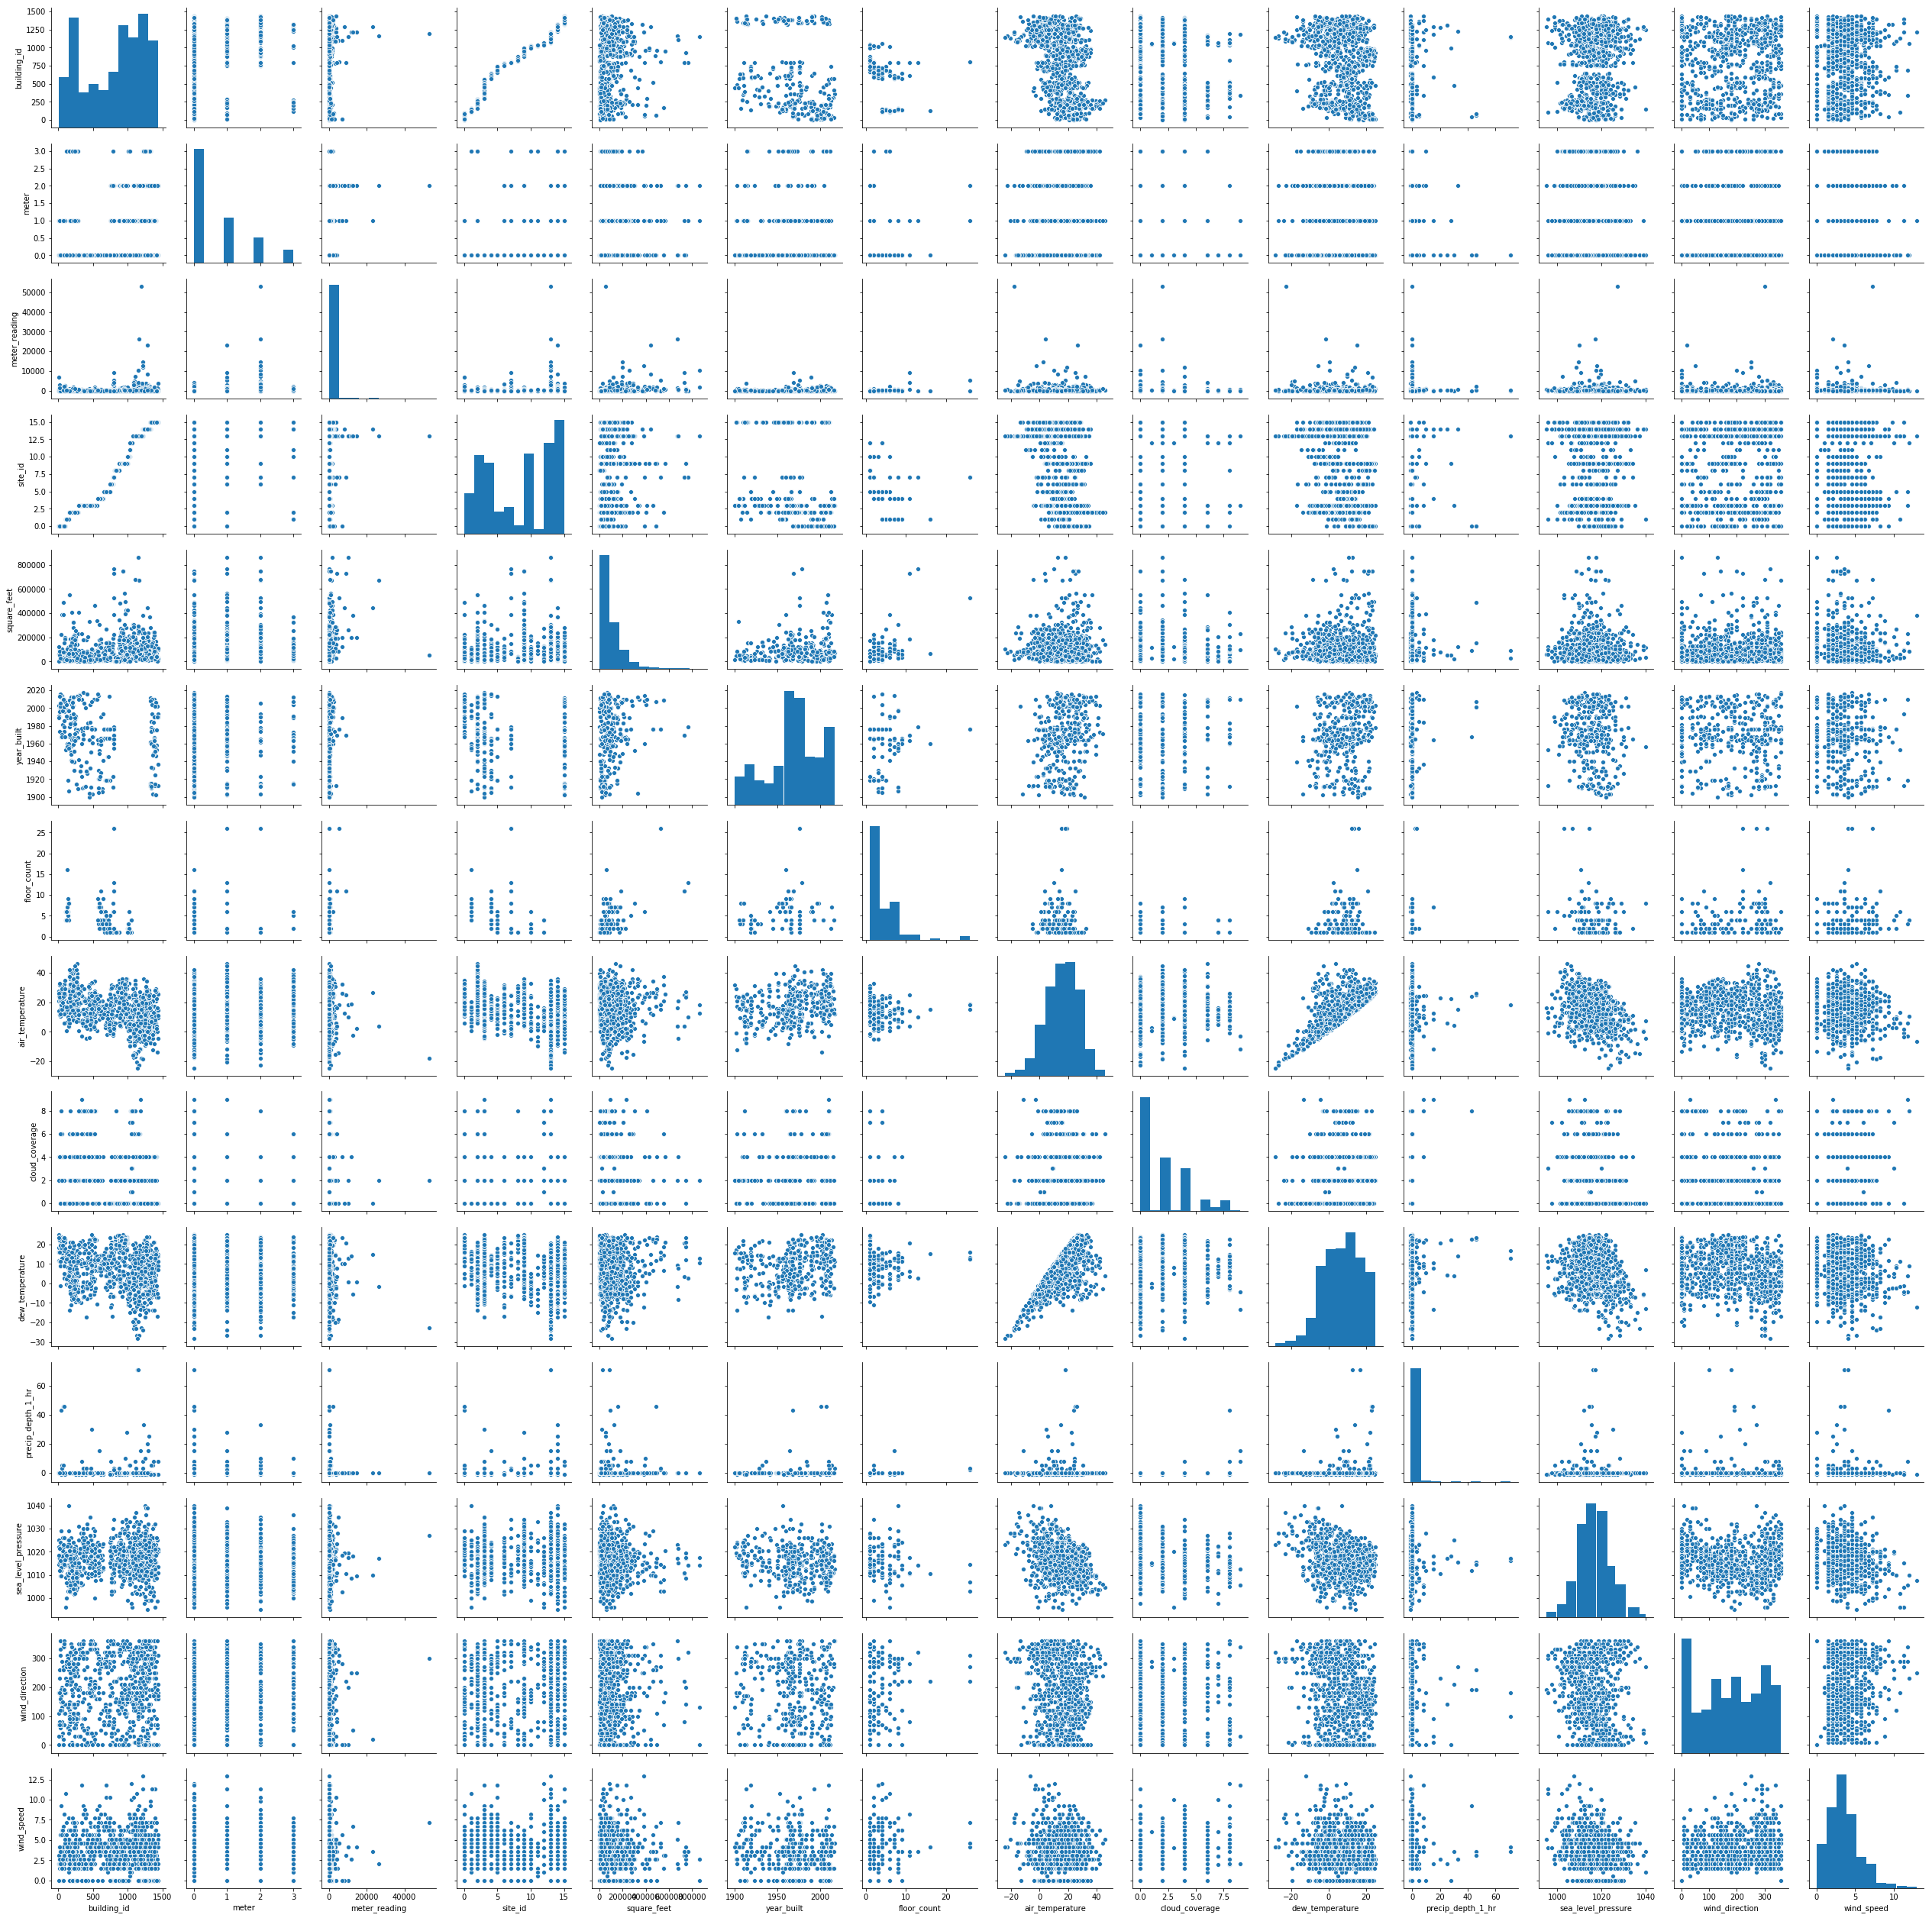

In [10]:
sns.pairplot(sample_train)

Although only 1k records were sampled, we can still see that 'meter_reading' is very left-skewed, so as 'square_feet', 'floor_count', 'cloud_coverage', 'precip_depth_1_hr'. **Log tranformation** would be needed, but before the transformation, I need to clean zero or negative values, which are invalid to log transform.

In [66]:
sample_train.describe(include='all')

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,1000.0,1000.0,1000,1000.000000,1000.0,1000,1000.000000,382.000000,165.000000,996.000000,564.000000,995.000000,836.000000,946.000000,937.000000,994.000000
unique,668.0,4.0,948,NaN,16.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,878.0,0.0,2016-01-12 01:00:00,NaN,13.0,Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5.0,631.0,3,NaN,146.0,410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2016-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-12-31 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,375.777924,NaN,NaN,108566.028000,inf,4.144531,15.992188,1.928711,7.863281,1.090820,inf,inf,3.468750
std,NaN,NaN,NaN,1168.124756,NaN,NaN,118628.124679,32.156250,4.117188,10.734375,2.455078,10.171875,9.304688,7.054688,113.437500,2.312500
min,NaN,NaN,NaN,0.000000,NaN,NaN,283.000000,1900.000000,1.000000,-21.000000,0.000000,-27.000000,-1.000000,976.000000,0.000000,0.000000
25%,NaN,NaN,NaN,19.694800,NaN,NaN,31233.000000,1950.250000,1.000000,8.296875,0.000000,0.600098,0.000000,1011.500000,80.000000,2.099609


In [67]:
skewed_col = ['meter_reading', 'square_feet', 'floor_count', 'cloud_coverage', 'precip_depth_1_hr']

sample_train[skewed_col].describe()

,meter_reading,square_feet,floor_count,cloud_coverage,precip_depth_1_hr
count,1000.000000,1000.000000,165.000000,564.000000,836.000000
mean,375.777924,108566.028000,4.144531,1.928711,1.090820
std,1168.124756,118628.124679,4.117188,2.455078,9.304688
min,0.000000,283.000000,1.000000,0.000000,-1.000000
25%,19.694800,31233.000000,1.000000,0.000000,0.000000
50%,77.921902,74799.500000,3.000000,0.000000,0.000000
75%,268.583755,139153.500000,5.000000,4.000000,0.000000
max,17625.000000,861524.000000,26.000000,9.000000,203.000000


### Log Normal transform skewed columns

In [76]:
def LogNormTransform(df, col):
    # replace zero with nan so as to skip log transform
    df[col+'_scaled'] = df[col].replace({0:np.nan})
    df[col+'_scaled'] = np.log(df[col+'_scaled'])

for col in skewed_col:
    LogNormTransform(sample_train, col)

/Users/wandajuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
scaled_col = [col+'_scaled' for col in skewed_col]

sample_train[scaled_col].describe()

,meter_reading_scaled,square_feet_scaled,floor_count_scaled,cloud_coverage_scaled,precip_depth_1_hr_scaled
count,924.000000,1000.000000,165.000000,276.000000,44.000000
mean,4.469130,11.033043,1.033203,1.238281,2.373047
std,1.891526,1.200196,0.877441,0.514648,1.170898
min,-3.218876,5.645447,0.000000,0.693359,0.693359
25%,3.345272,10.349231,0.000000,0.693359,1.098633
50%,4.604920,11.222563,1.098633,1.386719,2.302734
75%,5.721568,11.843331,1.609375,1.655029,3.247070
max,9.777074,13.666458,3.257812,2.197266,5.312500


Look better after Log transformation, but non-nan data is less. Then I need to consider whether it is neccessary to keep the feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a8c7e9160>,
      dtype=object)

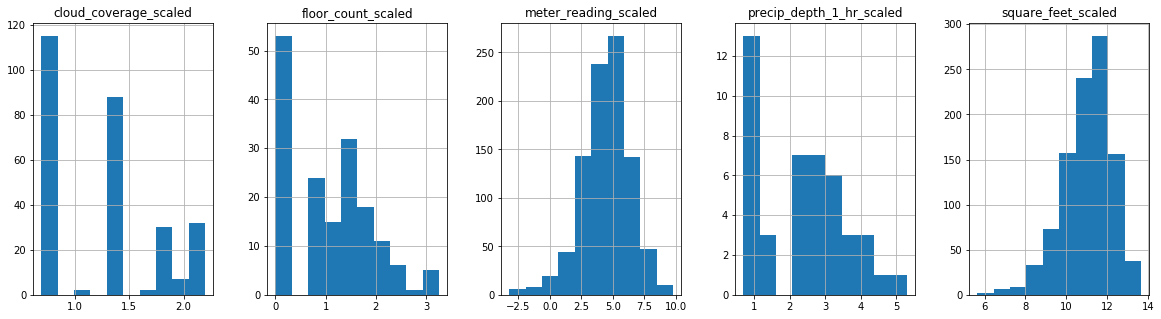

In [83]:
sample_train[scaled_col].hist(figsize=(20, 5), layout=(1, 5))

In [85]:
sample_train.drop(skewed_col, axis=1, inplace=True)
sample_train.isnull().sum()

building_id                   0
meter                         0
timestamp                     0
site_id                       0
primary_use                   0
year_built                  618
air_temperature               4
dew_temperature               5
sea_level_pressure           54
wind_direction               63
wind_speed                    6
meter_reading_scaled         76
square_feet_scaled            0
floor_count_scaled          835
cloud_coverage_scaled       724
precip_depth_1_hr_scaled    956
dtype: int64

In [86]:
sample_train.drop(['floor_count_scaled', 'cloud_coverage_scaled', 'precip_depth_1_hr_scaled'] , axis=1, inplace=True)
sample_train.isnull().sum()

building_id               0
meter                     0
timestamp                 0
site_id                   0
primary_use               0
year_built              618
air_temperature           4
dew_temperature           5
sea_level_pressure       54
wind_direction           63
wind_speed                6
meter_reading_scaled     76
square_feet_scaled        0
dtype: int64

In [87]:
# remove rows whose meter_reading is 0 or nan 
sample_train = sample_train.loc[sample_train['meter_reading_scaled'].notna()]

In [89]:
# pad zero's for year_built & others
sample_train = sample_train.fillna(0)
sample_train.isnull().sum()

building_id             0
meter                   0
timestamp               0
site_id                 0
primary_use             0
year_built              0
air_temperature         0
dew_temperature         0
sea_level_pressure      0
wind_direction          0
wind_speed              0
meter_reading_scaled    0
square_feet_scaled      0
dtype: int64

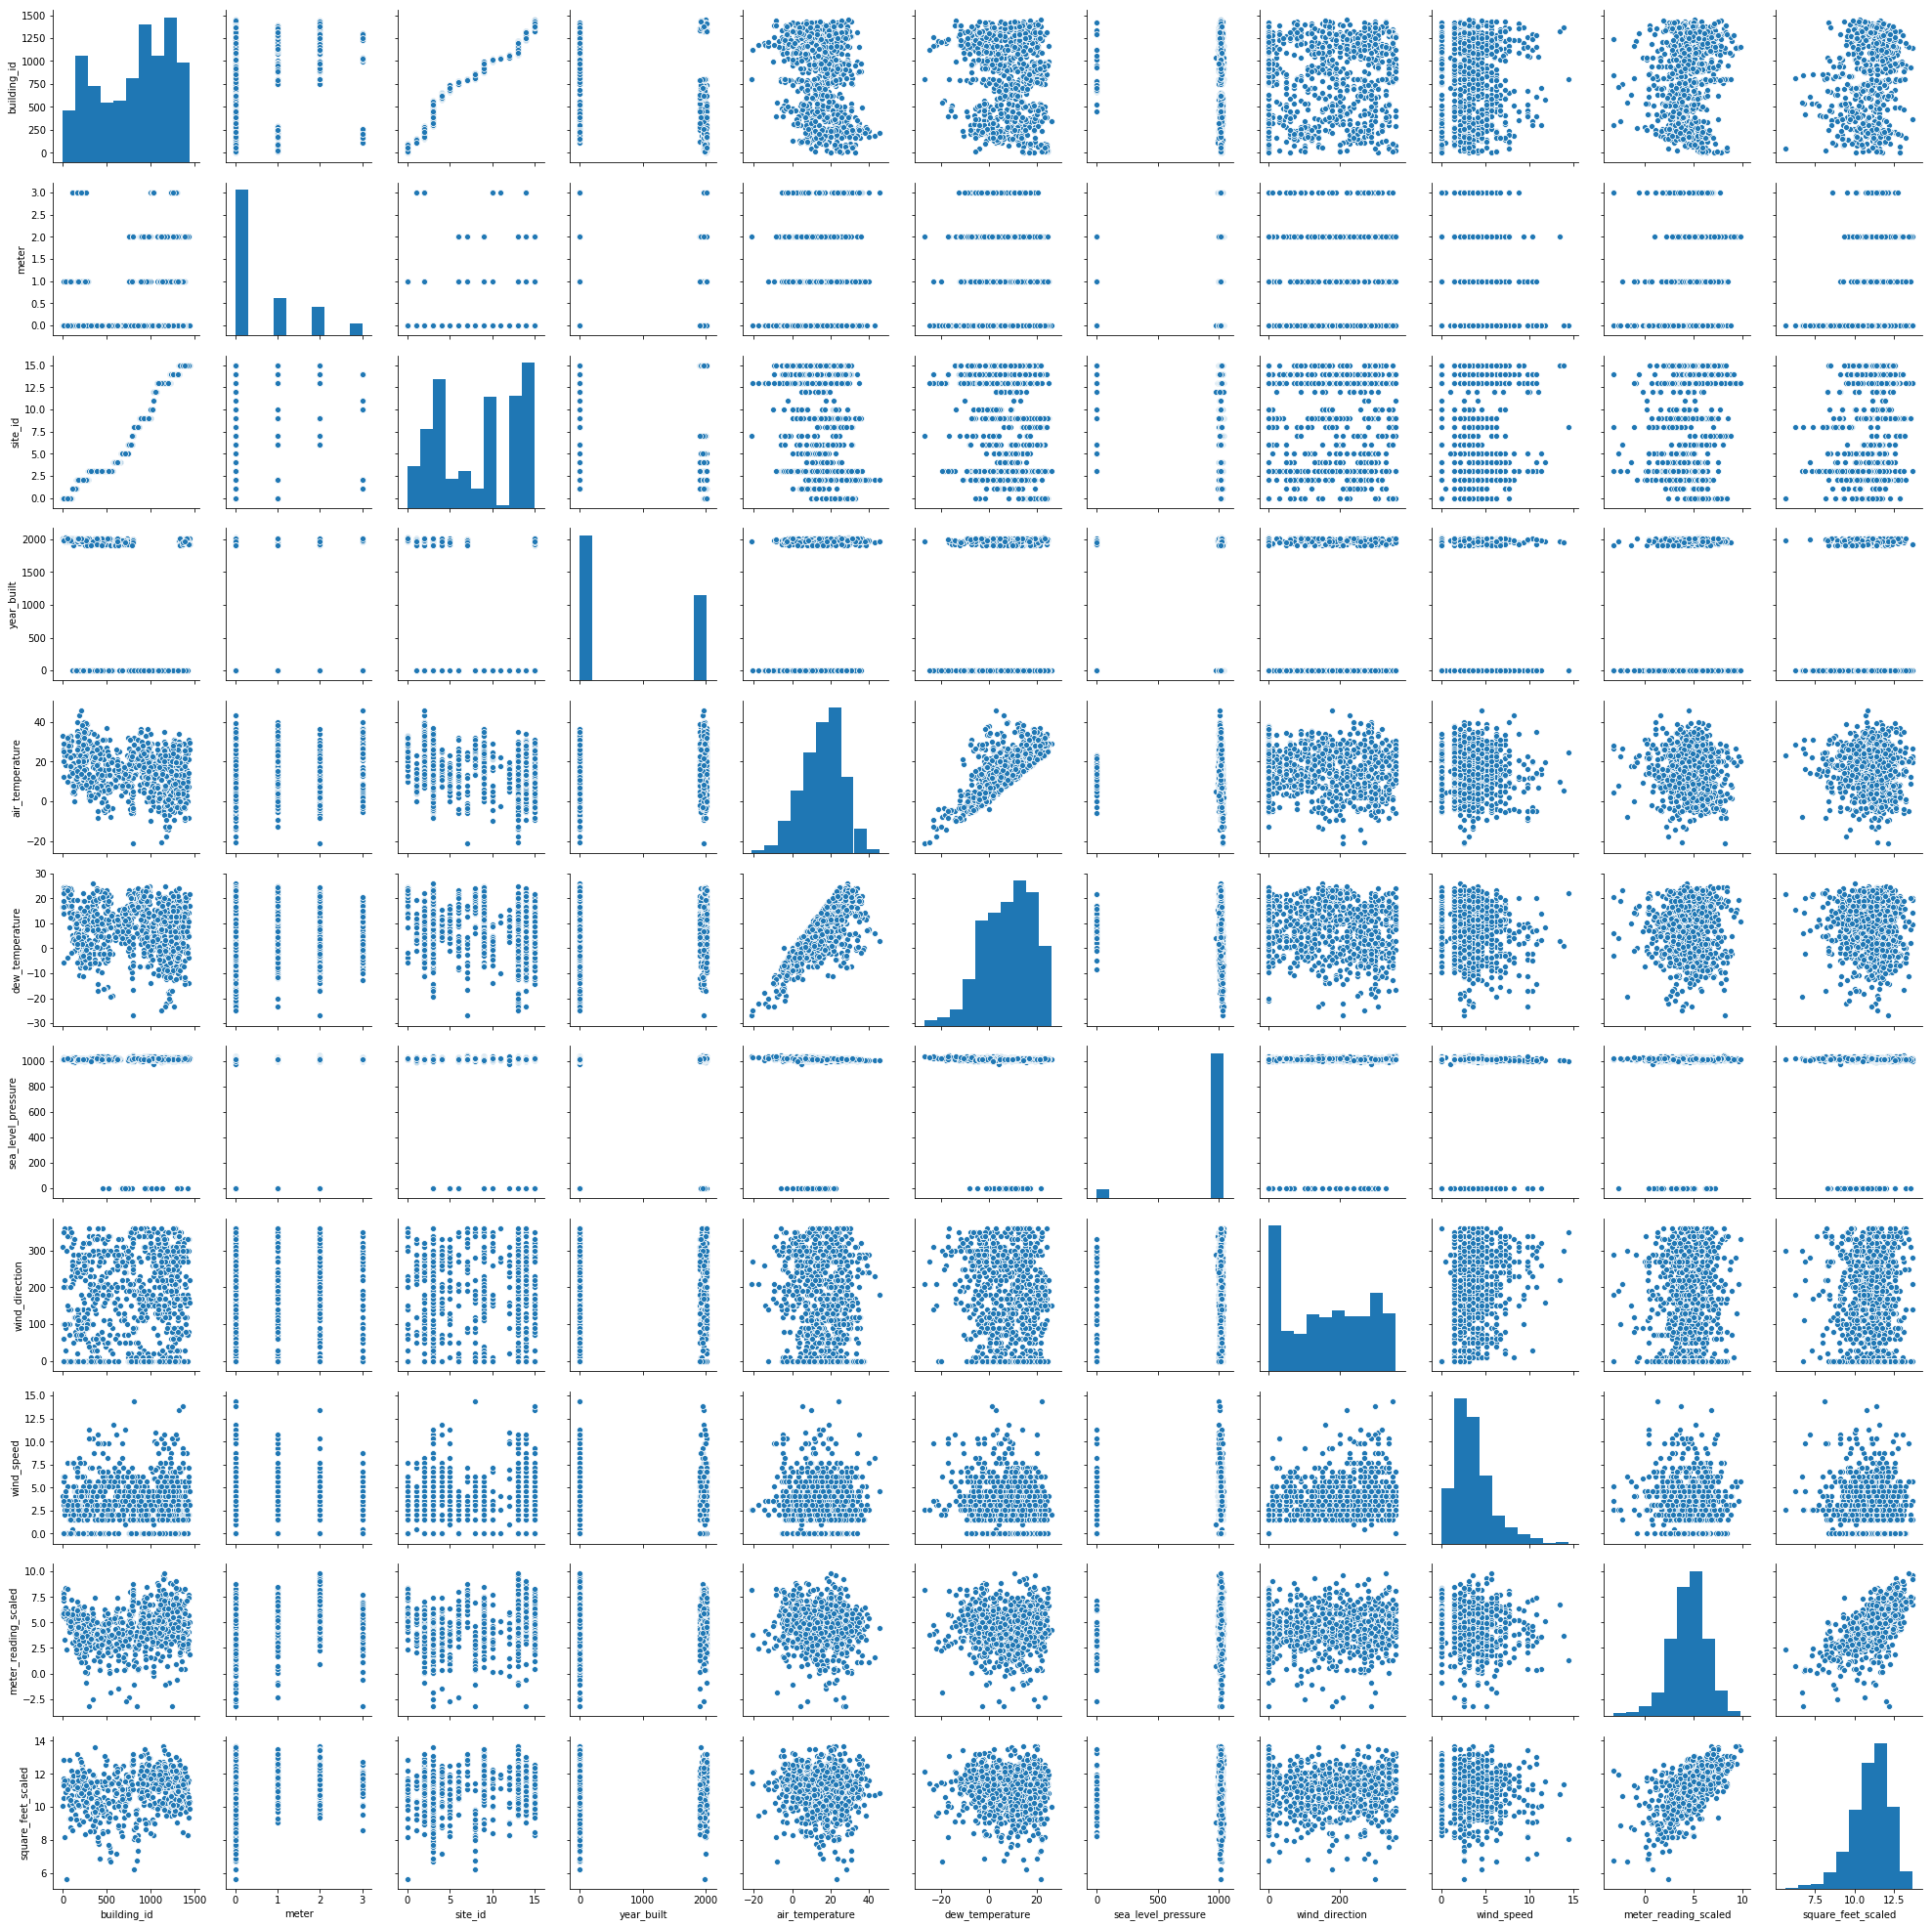

In [91]:
sns.pairplot(sample_train)

### OneHot encoding for categorical features

In [92]:
sample_train.dtypes

building_id                   category
meter                         category
timestamp               datetime64[ns]
site_id                       category
primary_use                     object
year_built                     float16
air_temperature                float16
dew_temperature                float16
sea_level_pressure             float16
wind_direction                 float16
wind_speed                     float16
meter_reading_scaled           float32
square_feet_scaled             float64
dtype: object

In [94]:
df = pd.get_dummies(sample_train, drop_first=True)
df.dtypes

timestamp                                    datetime64[ns]
year_built                                          float16
air_temperature                                     float16
dew_temperature                                     float16
sea_level_pressure                                  float16
wind_direction                                      float16
wind_speed                                          float16
meter_reading_scaled                                float32
square_feet_scaled                                  float64
building_id_1                                         uint8
building_id_2                                         uint8
building_id_3                                         uint8
building_id_4                                         uint8
building_id_5                                         uint8
building_id_6                                         uint8
building_id_7                                         uint8
building_id_8                           

In [95]:
df.shape

(924, 1490)

In [96]:
# prepare feature X and label y
X = df.drop('meter_reading_scaled', axis=1)
y = df['meter_reading_scaled']

In [98]:
# timestamp is not able to serve as a feature for regression
import datetime as dt
X['timestamp'] = X['timestamp'].map(dt.datetime.toordinal)
X['timestamp'].describe()

count       924.000000
mean     736149.701299
std         104.208473
min      735965.000000
25%      736060.750000
50%      736150.500000
75%      736237.250000
max      736329.000000
Name: timestamp, dtype: float64

In [101]:
# normalize the numerical timestamp
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X['timestamp'] = scaler.fit_transform(X['timestamp'].values.reshape(-1, 1))
X['timestamp'].describe()

count    924.000000
mean       0.507421
std        0.286287
min        0.000000
25%        0.263049
50%        0.509615
75%        0.747940
max        1.000000
Name: timestamp, dtype: float64

In [102]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
lr.score(X, y)

0.8988872118510108

In [107]:
lr.coef_, lr.intercept_

(array([ 1.49946267e-02,  1.50514816e-04, -2.15402451e-03, ...,
        -1.29442756e+00,  1.61255421e+00, -8.10938303e-01]),
 -4.769722399368346)

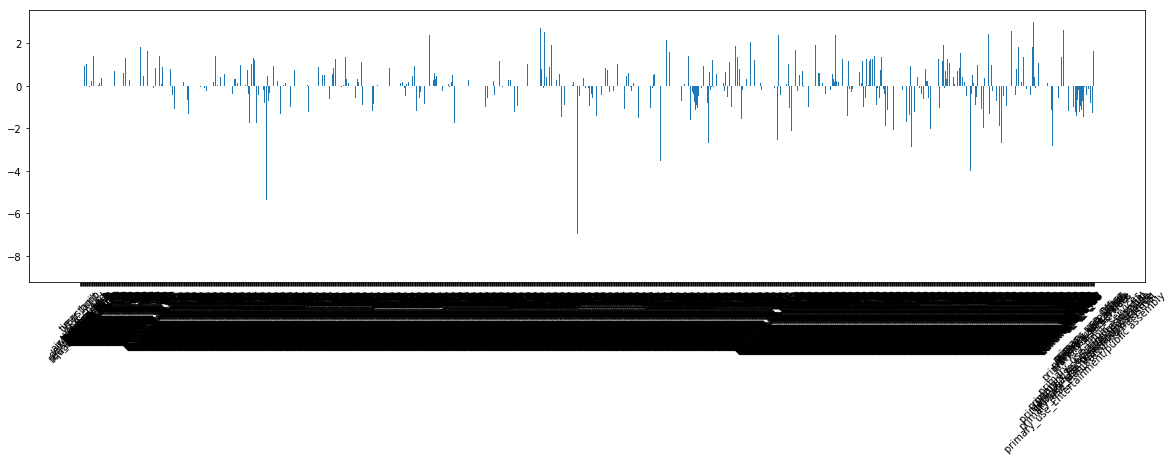

In [117]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(lr.coef_)), lr.coef_)
plt.xticks(np.arange(len(X.columns)), X.columns, rotation=45)
plt.show()

In [119]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso()
lasso.fit(X, y)
print(f'Lasso\'s r^2 score: {lasso.score(X, y)}')
ridge = Ridge()
ridge.fit(X, y)
print(f'Ridge\'s r^2 score: {ridge.score(X, y)}')

Lasso's r^2 score: 0.18300239447914413
Ridge's r^2 score: 0.8263515055858052
